s1301a - 10:03 min file

s02-1 - 22 sec file

Window size is the amount of time over which a waveform is sampled, known as time record, expressed in samples. For example, a window size of 128 samples at a sample rate of 48 kHz. Equals a time record of 128 samples x 1/48000 seconds = 0.0027 seconds or 2.7 milliseconds.

Window length is the length of the fixed intervals in which STFT divides the signal. Hop length is the length of the non-intersecting portion of window length. Overlap length is the length of the intersecting portion of the window length.

In [44]:
10*60+3, 603*16000

(603, 9648000)

In [45]:
22, 22*16000

(22, 352000)

In [40]:
# !pip install librosa

In [41]:
import soundfile as sf
import os
import pyfoal
import pypar
import librosa
import torchaudio
from scipy.io import wavfile


In [42]:
# filename = './s1301a.wav'
filename = './s02-1.wav'

### Soundfile

In [47]:
data, sr = sf.read(filename)


In [65]:
data

array([3.05175781e-04, 2.44140625e-04, 9.15527344e-05, ...,
       5.49316406e-04, 4.88281250e-04, 3.96728516e-04])

In [57]:
data.shape, sr

((348026,), 16000)

### Size

In [50]:
os.path.getsize(filename) // 2

348048

### Librosa

In [53]:
data_librosa, sr = librosa.load(filename, sr=16000)

In [54]:
data_librosa.shape

(348026,)

In [64]:
data_librosa

array([3.0517578e-04, 2.4414062e-04, 9.1552734e-05, ..., 5.4931641e-04,
       4.8828125e-04, 3.9672852e-04], dtype=float32)

In [55]:
librosa.get_duration(data_librosa)

/home/pranav/conda/envs/prominence-est-conda-py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[3.0517578e-04 2.4414062e-04 9.1552734e-05 ... 5.4931641e-04 4.8828125e-04
 3.9672852e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


15.783492063492064

### Torchaudio

In [58]:
data_torch, sr = torchaudio.load(filename)

In [63]:
data_torch

tensor([[3.0518e-04, 2.4414e-04, 9.1553e-05,  ..., 5.4932e-04, 4.8828e-04,
         3.9673e-04]])

In [59]:
data_torch.shape

torch.Size([1, 348026])

### Scipy wavefile

In [60]:
sr, data_scipy = wavfile.read(filename)

In [61]:
data_scipy, data_scipy.shape

(array([10,  8,  3, ..., 18, 16, 13], dtype=int16), (348026,))

In [62]:
window_length_ms = 10

window_length = int((window_length_ms/1000)*sr)
print('Window length in samples ' + str(window_length))


Window length in samples 160


### Audio load

In [9]:
import emphases

In [10]:
audio = emphases.load.audio('../data/cache/Buckeye/wavs/s02-1.wav')

In [13]:
audio.shape, audio.shape[-1] // emphases.HOPSIZE

(torch.Size([1, 348026]), 2175)

### Mel Exp

In [48]:
import emphases
import torch

In [49]:
mel_loader = emphases.load.MelSpectrogram()


/home/pranav/prominence-estimation-exp/emphases/emphases/load.py:56: FutureWarning: Pass sr=16000, n_fft=1024, n_mels=80 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  emphases.NUM_MELS


In [50]:
audio = emphases.load.audio('../data/cache/Buckeye/wavs/s03-1.wav')
audio2 = emphases.load.audio('../data/cache/Buckeye/wavs/s11-1.wav')

In [51]:
mel_spectrogram1 = mel_loader.forward(audio)
mel_spectrogram1.shape

torch.Size([1, 80, 1352])

In [52]:
audio[:, :494].shape

torch.Size([1, 494])

In [53]:
mel_spectrogram2 = mel_loader.forward(audio2)
mel_spectrogram2.shape

torch.Size([1, 80, 1502])

In [54]:
mel_spectrogram1.shape[-1]

1352

In [55]:
mel_spectrogram = [mel_spectrogram1, mel_spectrogram2]

In [56]:
mel_lengths = torch.tensor(
    [mel.shape[-1] for mel in mel_spectrogram], 
    dtype=torch.long)

max_mel_lengths = mel_lengths.max()

In [57]:
mel_lengths.max().item()

1502

### Checks

In [1]:
# import emphases
# import pypar
# import os
# import torch
# import functools

In [2]:
# train_stems = emphases.load.partition('Buckeye')['train']

In [3]:
# with open('../data/cache/Buckeye/annotation/s11-1.prom', 'r') as f:
#     data = f.read()
# # first line is header, skip it
# lines = [x.split('\t') for x in data.split('\n')[1:]]
# proms = torch.tensor([float(x[4]) for x in lines[:-1]])


In [4]:
# cache = emphases.CACHE_DIR / 'Buckeye'
# for stem in train_stems:
#     alignment = pypar.Alignment(
#         cache / 'alignment' / f'{stem}.TextGrid')
#     prominence = emphases.load.load_prominence(cache / 'annotation' / f'{stem}.prom')
# #     assert (len(alignment.word_bounds(emphases.SAMPLE_RATE)) == prominence.shape[0]), f'{stem} array length mismatch b/w input and ground truth'


In [1]:
# input_channels = emphases.NUM_MELS
# output_channels = 1
# hidden_channels = 128

# conv_fn = functools.partial(
#     torch.nn.Conv1d,
#     kernel_size=5,
#     padding='same')
# layers = torch.nn.Sequential(
#             conv_fn(input_channels, hidden_channels),
#             torch.nn.ReLU(),
#             conv_fn(hidden_channels, hidden_channels),
#             torch.nn.ReLU(),
#             conv_fn(hidden_channels, output_channels))
# sample_input = torch.randn(32, 80, 1300)
# layers(sample_input).shape

In [2]:
import emphases
import pypar
import os
import torch
import functools
import numpy as np
import seaborn as sns
import tqdm

In [3]:
train_loader, valid_loader = emphases.data.loaders('Buckeye', 'train', 'valid', gpu=None)

In [4]:
train_loader.dataset.lengths, train_loader.dataset.spectrogram_lengths

([769069, 456913, 559939, 408149, 585433, 438593, 654307, 696081, 608939],
 [1502, 892, 1093, 797, 1143, 856, 1278, 1359, 1189])

In [5]:
np.histogram(train_loader.dataset.spectrogram_lengths)

(array([2, 1, 0, 0, 2, 1, 1, 1, 0, 1]),
 array([ 797. ,  867.5,  938. , 1008.5, 1079. , 1149.5, 1220. , 1290.5,
        1361. , 1431.5, 1502. ]))

<AxesSubplot:ylabel='Count'>

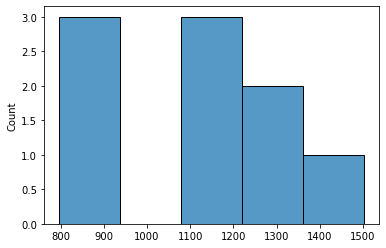

In [6]:
sns.histplot(train_loader.dataset.spectrogram_lengths)

In [7]:
# dir(train_loader)

In [8]:
len(train_loader.dataset)

9

In [9]:
train_loader.batch_sampler.set_epoch(0// len(train_loader.dataset))

In [10]:
all_batches = []
for batch in train_loader:
    all_batches.append(batch)

64it [00:00, 212.81it/s]
64it [00:00, 166.06it/s]


In [11]:
all_batches

[(tensor([[[ 1.2695e-02,  1.4282e-02,  1.6174e-02,  ..., -1.2207e-03,
            -1.3428e-03, -1.3428e-03]],
  
          [[ 3.0518e-04,  2.4414e-04,  9.1553e-05,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],
  
          [[ 6.8359e-03,  4.3640e-03,  3.8452e-03,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],
  
          ...,
  
          [[ 3.0518e-04,  2.4414e-04,  9.1553e-05,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],
  
          [[ 6.8359e-03,  4.3640e-03,  3.8452e-03,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],
  
          [[-1.1200e-02, -9.1553e-03, -1.0498e-02,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]]]),
  tensor([[[-1.5837, -2.1460, -2.7604,  ..., -2.9138, -2.9100, -2.8818],
           [-1.4098, -1.7689, -1.8389,  ..., -3.0151, -3.1621, -3.2071],
           [-0.9274, -1.0536, -1.0062,  ..., -2.7224, -2.7972, -2.9873],
           ...,
           [-3.5180, -3.4026, -3.5648,  ..., -4.0925, -4.2359, -4.1261

In [12]:
batch[0].shape

torch.Size([64, 1, 292640])

In [13]:
batch[1][11]

tensor([[-2.1366, -2.2048, -2.2406,  ..., -1.7020, -1.6793, -1.6940],
        [-2.0863, -2.0348, -1.8803,  ..., -1.5518, -1.6411, -1.4532],
        [-1.6193, -1.6189, -1.7209,  ..., -1.6993, -1.4689, -1.3902],
        ...,
        [-3.8162, -3.6503, -3.7346,  ..., -4.3252, -4.4712, -4.5398],
        [-3.9394, -3.7676, -3.8023,  ..., -4.3797, -4.3739, -4.4116],
        [-3.8769, -3.7066, -3.8541,  ..., -4.4424, -4.5870, -4.4964]])

In [14]:
batch[1]

tensor([[[-2.8031, -2.6662, -2.6978,  ...,  0.0000,  0.0000,  0.0000],
         [-3.2410, -2.9573, -2.7289,  ...,  0.0000,  0.0000,  0.0000],
         [-3.3242, -3.1488, -2.8239,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-4.0813, -3.9813, -3.7959,  ...,  0.0000,  0.0000,  0.0000],
         [-4.3043, -4.1931, -4.0255,  ...,  0.0000,  0.0000,  0.0000],
         [-4.4372, -4.3796, -4.3331,  ...,  0.0000,  0.0000,  0.0000]],

        [[-1.8463, -1.8303, -1.7620,  ...,  0.0000,  0.0000,  0.0000],
         [-1.7866, -1.6630, -1.6487,  ...,  0.0000,  0.0000,  0.0000],
         [-1.6644, -2.0592, -2.3784,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-3.7781, -3.0310, -2.3891,  ...,  0.0000,  0.0000,  0.0000],
         [-3.7495, -3.0431, -2.5668,  ...,  0.0000,  0.0000,  0.0000],
         [-3.7939, -3.1405, -2.6581,  ...,  0.0000,  0.0000,  0.0000]],

        [[-2.5467, -2.7873, -2.8456,  ...,  0.0000,  0.0000,  0.0000],
         [-2.5151, -2.7337, -2.8030,  ...,  0

In [15]:
batch[1].shape

torch.Size([64, 80, 1143])

In [16]:
batch[2][0], batch[2].shape

(tensor([[ 3.1250e-02,  0.0000e+00,  6.8750e-01,  0.0000e+00,  0.0000e+00,
           4.3750e-01,  6.2500e-02,  4.0625e-01,  5.9375e-01,  0.0000e+00,
           9.3750e-02,  0.0000e+00,  9.3750e-02,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  9.0625e-01,  0.0000e+00,  0.0000e+00,  3.1250e-01,
           4.6875e-01,  3.4375e-01,  4.6875e-01,  3.1250e-01,  0.0000e+00,
           0.0000e+00,  3.7500e-01,  3.1250e-01,  3.7500e-01,  1.2500e-01,
           3.4375e-01,  2.5000e-01,  3.4375e-01,  1.5819e+20,  4.9983e-10,
           9.3564e-40, -7.2765e-01, -4.3468e-01,  3.5964e-41,  0.0000e+00,
          -3.4925e-03,  4.5722e-41, -3.4925e-03,  4.5722e-41,  3.0790e+24,
           3.0728e-41,  3.0790e+24,  3.0728e-41, -1.8981e+00, -2.1088e+00,
          -1.7134e+00, -1.7547e+00, -1.9733e+00, -2.1370e+00, -2.1466e+00,
          -2.4050e+00]]),
 torch.Size([64, 1, 56]))

In [17]:
len(batch[3])

64

In [18]:
batch[4]

tensor([33, 56, 49, 52, 33, 56, 49, 52, 33, 56, 49, 52, 33, 56, 49, 52, 33, 56,
        49, 52, 33, 56, 49, 52, 33, 56, 49, 52, 33, 56, 49, 52, 33, 56, 49, 52,
        33, 56, 49, 52, 33, 56, 49, 52, 33, 56, 49, 52, 33, 56, 49, 52, 33, 56,
        49, 52, 33, 56, 49, 52, 33, 56, 49, 52])

In [19]:
batch[5]

tensor([1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829,
        1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829,
        1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829,
        1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829,
        1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829, 1427, 1749, 1370, 1829,
        1427, 1749, 1370, 1829])

In [20]:
torch.is_tensor(batch[3])

False

In [21]:
s = (item.to('cpu') if torch.is_tensor(item) else item for item in batch)

In [22]:
(padded_audio,
padded_mel_spectrogram,
padded_prominence,
word_bounds,
word_lengths,
frame_lengths) = s

In [23]:
padded_audio.shape

torch.Size([64, 1, 292640])

In [24]:
padded_mel_spectrogram.shape

torch.Size([64, 80, 1143])

In [25]:
len(word_bounds[0])

33

In [26]:
padded_prominence[0].shape

torch.Size([1, 56])

In [27]:
model = emphases.model.BaselineModel()

In [60]:
# model_input = (padded_mel_spectrogram)
model_input = (padded_audio[0:4])

In [61]:
output = model(model_input)

In [62]:
output.shape

torch.Size([4, 1, 292640])

### Slice the inputs wrt word bounds

Process the word bounds, split the torch tensor into chunks and then pass further into the network, grad true

In [84]:
word_bounds[0]

[(29, 44),
 (44, 64),
 (64, 94),
 (94, 107),
 (107, 116),
 (116, 189),
 (221, 247),
 (291, 329),
 (329, 401),
 (487, 507),
 (507, 540),
 (540, 564),
 (564, 602),
 (602, 625),
 (625, 654),
 (654, 672),
 (672, 723),
 (723, 751),
 (751, 770),
 (770, 805),
 (837, 888),
 (911, 965),
 (985, 1021),
 (1021, 1066),
 (1121, 1127),
 (1127, 1137),
 (1137, 1164),
 (1164, 1194),
 (1194, 1232),
 (1277, 1319),
 (1319, 1338),
 (1338, 1376),
 (1376, 1424)]

In [154]:
(1376-1424)*emphases.HOPSIZE

-7680

In [138]:
duration_slices = []
for bound in word_bounds[0]:
    dur = (bound[1] - bound[0])*emphases.HOPSIZE
    duration_slices.append(dur)

if sum(duration_slices)!=output.shape[-1]:
    duration_slices.append(output.shape[-1] - sum(duration_slices))

In [139]:
word_bounds[0][0]

(29, 44)

In [140]:
1424*emphases.HOPSIZE

227840

In [141]:
len(word_bounds[0])

33

In [142]:
word_bounds[0][1][0]*emphases.HOPSIZE, word_bounds[0][1][1]*emphases.HOPSIZE

(7040, 10240)

In [143]:
output.shape

torch.Size([4, 1, 292640])

In [144]:
output[0, :, 7040:10240].shape

torch.Size([1, 3200])

In [145]:
slices = torch.split(output[0, :, :][0], duration_slices)


In [155]:
slices

(tensor([-0.0515, -0.0184, -0.0091,  ..., -0.0154, -0.0151, -0.0149],
        grad_fn=<SplitWithSizesBackward0>),
 tensor([-0.0147, -0.0143, -0.0144,  ..., -0.0084, -0.0089, -0.0092],
        grad_fn=<SplitWithSizesBackward0>),
 tensor([-0.0090, -0.0080, -0.0066,  ..., -0.0241, -0.0237, -0.0231],
        grad_fn=<SplitWithSizesBackward0>),
 tensor([-0.0223, -0.0214, -0.0206,  ..., -0.0179, -0.0177, -0.0164],
        grad_fn=<SplitWithSizesBackward0>),
 tensor([-0.0134, -0.0103, -0.0075,  ..., -0.0105, -0.0107, -0.0112],
        grad_fn=<SplitWithSizesBackward0>),
 tensor([-0.0108, -0.0097, -0.0080,  ..., -0.0090, -0.0083, -0.0078],
        grad_fn=<SplitWithSizesBackward0>),
 tensor([-0.0076, -0.0073, -0.0072,  ..., -0.0140, -0.0140, -0.0140],
        grad_fn=<SplitWithSizesBackward0>),
 tensor([-0.0140, -0.0139, -0.0139,  ..., -0.0143, -0.0149, -0.0161],
        grad_fn=<SplitWithSizesBackward0>),
 tensor([-0.0167, -0.0161, -0.0148,  ..., -0.0127, -0.0126, -0.0126],
        grad_fn=<S

In [146]:
len(slices)

34

In [150]:
sum(duration_slices[:-1])

169280

In [126]:
slices[33]

tensor([-0.0164, -0.0158, -0.0160,  ...,  0.0122,  0.0344,  0.0539],
       grad_fn=<SplitWithSizesBackward0>)

In [118]:
len(duration_slices)

34

In [48]:
# audio, mel_spectrogram, prominence, word_bounds = train_loader.dataset.__getitem__(0)
# train_loader.dataset.lengths
# audio.shape[-1], audio.shape[-1]//emphases.HOPSIZE

### Model forward pass

In [26]:
# Get DDP rank
if torch.distributed.is_initialized():
    rank = torch.distributed.get_rank()
else:
    rank = None

gpu = None
# Get torch device
device = torch.device('cpu' if gpu is None else f'cuda:{gpu}')

#######################
# Create data loaders #
#######################

torch.manual_seed(emphases.RANDOM_SEED)
train_loader, valid_loader = emphases.data.loaders('Buckeye', 'train', 'valid', gpu)

#################
# Create models #
#################

# model = emphases.model.Model().to(device)
model = emphases.model.BaselineModel().to(device)

##################################################
# Maybe setup distributed data parallelism (DDP) #
##################################################

if rank is not None:
    model = torch.nn.parallel.DistributedDataParallel(
        model,
        device_ids=[rank])



In [27]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,
    betas=[.80, .99],
    eps=1e-9)



In [28]:
path = None
step = 0
scheduler_fn = functools.partial(
    torch.optim.lr_scheduler.ExponentialLR,
    gamma=emphases.LEARNING_RATE_DECAY,
    last_epoch=step // len(train_loader.dataset) if step else -1)
scheduler = scheduler_fn(optimizer)
# Automatic mixed precision (amp) gradient scaler
scaler = torch.cuda.amp.GradScaler()

# Get total number of steps
steps = emphases.NUM_STEPS

# Setup progress bar
if not rank:
    progress = tqdm.tqdm(
        initial=step,
        total=steps,
        dynamic_ncols=True,
        desc=f'Training {emphases.CONFIG}')


Training emphases:   0%|                                                                                                   | 0/300000 [00:00<?, ?it/s]

In [29]:
while step < steps:

    # Seed sampler
    train_loader.batch_sampler.set_epoch(step // len(train_loader.dataset))

    model.train()
    for batch in train_loader:

        # TODO - Unpack batch
        (
        padded_audio,
        padded_mel_spectrogram,
        padded_prominence,
        word_bounds,
        word_lengths,
        frame_lengths
        ) = (item.to(device) if torch.is_tensor(item) else item for item in batch)

        # Bundle training input
        model_input = (padded_mel_spectrogram)

        with torch.cuda.amp.autocast():

            (
            outputs
            ) = model.forward(model_input)

            # TODO - compute losses
            losses = 0.

        ######################
        # Optimize model #
        ######################

        optimizer.zero_grad()

        # Backward pass
        scaler.scale(losses).backward()

        # Update weights
        scaler.step(optimizer)

        # Update gradient scaler
        scaler.update()

        ###########
        # Logging #
        ###########

        if not rank:

            if step % emphases.LOG_INTERVAL == 0:

                # Log losses
                scalars = {
                    'loss/total': losses,
                    'learning_rate': optimizer.param_groups[0]['lr']}
                emphases.write.scalars(log_directory, step, scalars)

            ############
            # Evaluate #
            ############

            if step % emphases.EVALUATION_INTERVAL == 0:

                evaluate(
                    log_directory,
                    step,
                    generator,
                    valid_loader,
                    gpu)

            ###################
            # Save checkpoint #
            ###################

            if step and step % emphases.CHECKPOINT_INTERVAL == 0:
                emphases.checkpoint.save(
                    model,
                    optimizer,
                    step,
                    output_directory / f'{step:08d}.pt')

        # Update training step count
        if step >= steps:
            break
        step += 1

        # Update progress bar
        if not rank:
            progress.update()

    # Update learning rate every epoch
    scheduler.step()

# Close progress bar
if not rank:
    progress.close()

# Save final model
emphases.checkpoint.save(
    model,
    optimizer,
    step,
    output_directory / f'{step:08d}.pt')




0it [00:00, ?it/s]
17it [00:00, 164.13it/s]
0it [00:00, ?it/s]
34it [00:00, 160.17it/s]
20it [00:00, 193.91it/s]
51it [00:00, 158.09it/s]
64it [00:00, 157.22it/s]

64it [00:00, 152.77it/s]


ValueError: outputs must be a Tensor or an iterable of Tensors